## MULTIOUTPUT MODEL
---
- 다중입력 + 다중출력 모델

## [1] 데이터 준비
---

In [20]:
# 데이터 처리관련 모듈 로딩 -----------------------------------------------
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

In [21]:
boston = load_boston()

In [22]:
data = pd.DataFrame(boston.data)

In [23]:
data.columns = boston.feature_names

In [24]:
data['PRICE'] = boston.target
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## [2] 데이터 전처리
---

In [25]:
# 학습, 검증, 테스트 데이터 분할
train,test = train_test_split(data, test_size=0.2, random_state = 1)
train,val = train_test_split(train, test_size=0.2, random_state = 1)

In [26]:
# Helper functions
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

def format_output(data):
    y1 = data.pop('PRICE')
    y1 = np.array(y1)
    y2 = data.pop('PTRATIO')
    y2 = np.array(y2)
    return y1, y2

In [27]:
# PRICE, TRATIO 2가지 출력
# PTRATIO - pupil-teacher ratio by town  타운별 학생/교사 비율
train_stats = train.describe()

train_stats.pop('PRICE')
train_stats.pop('PTRATIO')
train_stats = train_stats.transpose()

train_Y = format_output(train)
test_Y = format_output(test)
val_Y = format_output(val)

In [28]:
# Normalize the training and test data
norm_train_X = np.array(norm(train))
norm_test_X = np.array(norm(test))
norm_val_X = np.array(norm(val))

## MODEL

In [29]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import plot_model
import tensorflow as tf

### [1]  모델 구성 

In [30]:
def build_model():
    
    # Layer 정의
    input_layer = Input(shape=(len(train .columns),))
    first_dense = Dense(units='128', activation='relu')(input_layer)
    
    # 출력 Layer 정의 : first dense ===>  Y1 output
    y1_output = Dense(units='1', name='price_output')(first_dense)
    second_dense = Dense(units='128',activation='relu')(first_dense)
    
    # 출력 Layer 정의 : second dense === >Y2 output 
    y2_output = Dense(units='1',name='ptratio_output')(second_dense)
    
    # Model 정의
    model = Model(inputs=input_layer,outputs=[y1_output, y2_output])
    return model

In [31]:
model = build_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 128)          1664        ['input_2[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 128)          16512       ['dense_2[0][0]']                
                                                                                                  
 price_output (Dense)           (None, 1)            129         ['dense_2[0][0]']                
                                                                                            

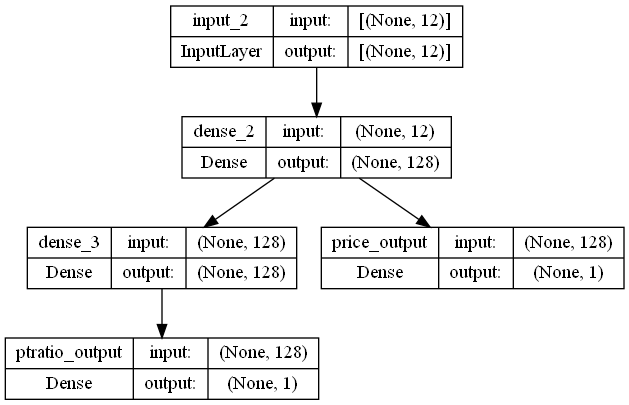

In [32]:
plot_model(model, show_shapes=True)

### [2] 모델 생성

In [33]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)

model.compile(optimizer=optimizer,
              loss={'price_output': 'mse', 'ptratio_output': 'mse'},
              metrics={'price_output':tf.keras.metrics.RootMeanSquaredError(),
                       'ptratio_output':tf.keras.metrics.RootMeanSquaredError()})

## [3] 학습

In [34]:
history = model.fit(norm_train_X, train_Y,
                    epochs=100, batch_size=10, 
                    validation_data=(norm_test_X, test_Y))

Epoch 1/100
33/33 [==============================] - 1s 8ms/step - loss: 517.3522 - price_output_loss: 373.2412 - ptratio_output_loss: 144.1111 - price_output_root_mean_squared_error: 19.3195 - ptratio_output_root_mean_squared_error: 12.0046 - val_loss: 157.5873 - val_price_output_loss: 138.7359 - val_ptratio_output_loss: 18.8514 - val_price_output_root_mean_squared_error: 11.7786 - val_ptratio_output_root_mean_squared_error: 4.3418
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 75.0843 - price_output_loss: 63.4784 - ptratio_output_loss: 11.6059 - price_output_root_mean_squared_error: 7.9673 - ptratio_output_root_mean_squared_error: 3.4067 - val_loss: 54.2474 - val_price_output_loss: 45.7667 - val_ptratio_output_loss: 8.4808 - val_price_output_root_mean_squared_error: 6.7651 - val_ptratio_output_root_mean_squared_error: 2.9122
Epoch 3/100
33/33 [==============================] - 0s 3ms/step - loss: 41.2051 - price_output_loss: 34.4508 - ptratio_output_loss: 6.

33/33 [==============================] - 0s 3ms/step - loss: 17.8187 - price_output_loss: 15.2171 - ptratio_output_loss: 2.6015 - price_output_root_mean_squared_error: 3.9009 - ptratio_output_root_mean_squared_error: 1.6129 - val_loss: 18.1014 - val_price_output_loss: 14.9712 - val_ptratio_output_loss: 3.1302 - val_price_output_root_mean_squared_error: 3.8693 - val_ptratio_output_root_mean_squared_error: 1.7692
Epoch 21/100
33/33 [==============================] - 0s 3ms/step - loss: 17.1855 - price_output_loss: 14.7151 - ptratio_output_loss: 2.4704 - price_output_root_mean_squared_error: 3.8360 - ptratio_output_root_mean_squared_error: 1.5718 - val_loss: 18.6615 - val_price_output_loss: 15.5375 - val_ptratio_output_loss: 3.1240 - val_price_output_root_mean_squared_error: 3.9418 - val_ptratio_output_root_mean_squared_error: 1.7675
Epoch 22/100
33/33 [==============================] - 0s 3ms/step - loss: 16.8478 - price_output_loss: 14.5159 - ptratio_output_loss: 2.3319 - price_output_r

33/33 [==============================] - 0s 4ms/step - loss: 13.9980 - price_output_loss: 12.1175 - ptratio_output_loss: 1.8806 - price_output_root_mean_squared_error: 3.4810 - ptratio_output_root_mean_squared_error: 1.3713 - val_loss: 15.3813 - val_price_output_loss: 12.7132 - val_ptratio_output_loss: 2.6681 - val_price_output_root_mean_squared_error: 3.5656 - val_ptratio_output_root_mean_squared_error: 1.6334
Epoch 40/100
33/33 [==============================] - 0s 4ms/step - loss: 13.9238 - price_output_loss: 12.0803 - ptratio_output_loss: 1.8434 - price_output_root_mean_squared_error: 3.4757 - ptratio_output_root_mean_squared_error: 1.3577 - val_loss: 15.3908 - val_price_output_loss: 12.4742 - val_ptratio_output_loss: 2.9167 - val_price_output_root_mean_squared_error: 3.5319 - val_ptratio_output_root_mean_squared_error: 1.7078
Epoch 41/100
33/33 [==============================] - 0s 3ms/step - loss: 13.7471 - price_output_loss: 11.9127 - ptratio_output_loss: 1.8344 - price_output_r

33/33 [==============================] - 0s 2ms/step - loss: 12.3568 - price_output_loss: 10.8432 - ptratio_output_loss: 1.5136 - price_output_root_mean_squared_error: 3.2929 - ptratio_output_root_mean_squared_error: 1.2303 - val_loss: 14.5205 - val_price_output_loss: 12.0148 - val_ptratio_output_loss: 2.5057 - val_price_output_root_mean_squared_error: 3.4662 - val_ptratio_output_root_mean_squared_error: 1.5829
Epoch 59/100
33/33 [==============================] - 0s 2ms/step - loss: 12.4634 - price_output_loss: 10.9760 - ptratio_output_loss: 1.4874 - price_output_root_mean_squared_error: 3.3130 - ptratio_output_root_mean_squared_error: 1.2196 - val_loss: 14.6450 - val_price_output_loss: 12.0192 - val_ptratio_output_loss: 2.6257 - val_price_output_root_mean_squared_error: 3.4669 - val_ptratio_output_root_mean_squared_error: 1.6204
Epoch 60/100
33/33 [==============================] - 0s 3ms/step - loss: 12.3009 - price_output_loss: 10.8459 - ptratio_output_loss: 1.4550 - price_output_r

33/33 [==============================] - 0s 4ms/step - loss: 11.5071 - price_output_loss: 10.1648 - ptratio_output_loss: 1.3423 - price_output_root_mean_squared_error: 3.1882 - ptratio_output_root_mean_squared_error: 1.1586 - val_loss: 13.8611 - val_price_output_loss: 11.6111 - val_ptratio_output_loss: 2.2500 - val_price_output_root_mean_squared_error: 3.4075 - val_ptratio_output_root_mean_squared_error: 1.5000
Epoch 78/100
33/33 [==============================] - 0s 3ms/step - loss: 11.2076 - price_output_loss: 9.9479 - ptratio_output_loss: 1.2598 - price_output_root_mean_squared_error: 3.1540 - ptratio_output_root_mean_squared_error: 1.1224 - val_loss: 14.7145 - val_price_output_loss: 12.1276 - val_ptratio_output_loss: 2.5869 - val_price_output_root_mean_squared_error: 3.4825 - val_ptratio_output_root_mean_squared_error: 1.6084
Epoch 79/100
33/33 [==============================] - 0s 3ms/step - loss: 11.2532 - price_output_loss: 9.9608 - ptratio_output_loss: 1.2924 - price_output_roo

33/33 [==============================] - 0s 2ms/step - loss: 10.6779 - price_output_loss: 9.5715 - ptratio_output_loss: 1.1064 - price_output_root_mean_squared_error: 3.0938 - ptratio_output_root_mean_squared_error: 1.0519 - val_loss: 14.2071 - val_price_output_loss: 12.0583 - val_ptratio_output_loss: 2.1488 - val_price_output_root_mean_squared_error: 3.4725 - val_ptratio_output_root_mean_squared_error: 1.4659
Epoch 97/100
33/33 [==============================] - 0s 2ms/step - loss: 10.4989 - price_output_loss: 9.4342 - ptratio_output_loss: 1.0647 - price_output_root_mean_squared_error: 3.0715 - ptratio_output_root_mean_squared_error: 1.0318 - val_loss: 14.0439 - val_price_output_loss: 11.8029 - val_ptratio_output_loss: 2.2410 - val_price_output_root_mean_squared_error: 3.4355 - val_ptratio_output_root_mean_squared_error: 1.4970
Epoch 98/100
33/33 [==============================] - 0s 2ms/step - loss: 10.5648 - price_output_loss: 9.4821 - ptratio_output_loss: 1.0827 - price_output_root

### [4] 평가

In [35]:
loss,Y1_loss,Y2_loss,Y1_rmse,Y2_rmse=model.evaluate(x=norm_val_X, y=val_Y)
print()
print(f'loss: {loss}')
print(f'price_loss: {Y1_loss}')
print(f'ptratio_loss: {Y2_loss}')
print(f'price_rmse: {Y1_rmse}')
print(f'ptratio_rmse: {Y2_rmse}')

3/3 [==============================] - 0s 3ms/step - loss: 15.2409 - price_output_loss: 13.1338 - ptratio_output_loss: 2.1071 - price_output_root_mean_squared_error: 3.6241 - ptratio_output_root_mean_squared_error: 1.4516

loss: 15.240870475769043
price_loss: 13.133809089660645
ptratio_loss: 2.1070618629455566
price_rmse: 3.6240596771240234
ptratio_rmse: 1.4515721797943115


### [5] 예측 - 새 데이터

4/4 [==============================] - 0s 2ms/step


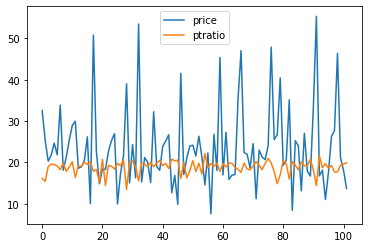

In [61]:
Y_pred = model.predict(norm_test_X)

plt.plot(Y_pred[0])
plt.plot(Y_pred[1])
plt.legend(['price', 'ptratio'])